In [1]:
'''
SimpleGAN 

This notebook is meant to be a simple GAN example for numeric info 
(maybe image and text examples also)
'''

'\nSimpleGAN \n\nThis notebook is meant to be a simple GAN example for numeric info \n(maybe image and text examples also)\n'

In [23]:
import torch 
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import math 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
%matplotlib inline

the first numeric GAN example will be generating sine numerics 
the GAN will generate (x1, x2) numbers from random input 

In [4]:
#create the training data for the GAN to learn its latent space 
x_input = torch.rand(1000)
y_output = torch.sin(2 * math.pi * x_input)

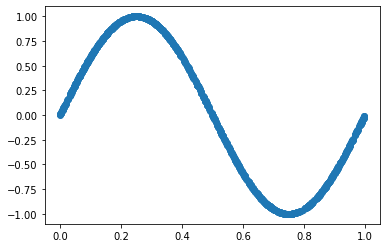

In [5]:
plt.scatter(x_input, y_output)

In [6]:
#save the input and output tensors as a tensor
training_set = torch.zeros(len(x_input), 2)

In [7]:
training_set[:, 0] = x_input

In [8]:
training_set[:, 1] = y_output

In [9]:
training_set

tensor([[ 0.9337, -0.4044],
        [ 0.5533, -0.3288],
        [ 0.1215,  0.6915],
        ...,
        [ 0.9340, -0.4031],
        [ 0.3596,  0.7722],
        [ 0.5450, -0.2790]])

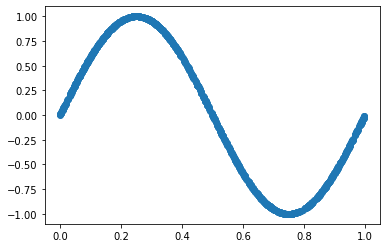

In [10]:
#verify the training set tensor is correct 
plt.scatter(training_set[:, 0], training_set[:, 1])

In [11]:
#create the data loader from torch.utils to handle batching the data 
#this dataset is used to calculate the generator's loss
training_data = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=True)

In [12]:
#create a random generator to match the dimensions of the output (x1, x2)
#we need this random noise for the GAN to use as input
def get_random_noise(z_dim):
    return torch.randn((z_dim, 2))

In [13]:
#create the generator 
#the first layer is a 2 for the 2 dimensions of the input data (x1, x2)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32), 
            nn.ReLU(), 
            nn.Linear(32, 64), 
            nn.ReLU(), 
            nn.Linear(64, 128), 
            nn.ReLU(), 
            nn.Linear(128, 2))
        
    def forward(self, data):
        return self.model(data)

In [14]:
#create the discriminator 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), 
            nn.ReLU(), 
            nn.Linear(256, 128), 
            nn.ReLU(), 
            nn.Linear(128, 64), 
            nn.ReLU(), 
            nn.Linear(64, 1), 
            nn.Sigmoid())
        
    def forward(self, data):
        return self.model(data)

In [32]:
gen = Generator()
disc = Discriminator()

In [33]:
loss = nn.BCELoss()
lr = 0.0001
batch_size = 50
epochs = 500

In [34]:
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

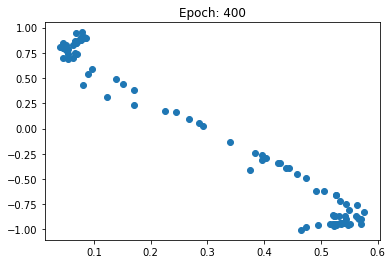

In [35]:
#loop through the entire dataset [epoch] number of times
writer = SummaryWriter()
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
random_input = get_random_noise(batch_size)
plot_output = gen(random_input).detach().numpy()
plt.scatter(plot_output[:, 0], plot_output[:, 1])
plt.draw()
for i in range(0, epochs):
    #for each batch, train and update the models
    for n, samples in enumerate(training_data):
        #the training data is the REAL data, the fake data is randomly generated
        #label the real samples from the batch as real with a 1
        fake_output = gen(get_random_noise(len(samples)))
        fake_labels = torch.zeros((len(samples), 1))
        real_labels = torch.ones((len(samples), 1))
        all_samples = torch.cat((samples, fake_output))
        all_labels = torch.cat((real_labels, fake_labels))
        
        #get the discriminator's predictions first 
        disc.zero_grad()
        disc_output = disc(all_samples)
        #the loss needs to have the model output first 
        disc_loss = loss(disc_output, all_labels)
        disc_loss.backward()
        disc_opt.step()
        
        #train the generator
        gen.zero_grad()
        random_input = get_random_noise(len(samples))
        gen_output = gen(random_input)
        #we want the genertor to be corrected based on feedback from the discriminator
        #in order to correct it, we want the generator lables to "appear" real so we use the
        #real label for the generator when calculating the loss
        gen_loss = loss(disc(gen_output), real_labels)
        writer.add_scalar("Gen Loss/train", gen_loss, i)
        writer.add_scalar("Disc Loss/train", disc_loss, i)
        gen_loss.backward()
        gen_opt.step()
    
    if i % 100 == 0:
        clear_output(wait=True)
        plot_output = gen_output.detach().numpy()
        plt.title(f"Epoch: {i}")
        plt.scatter(plot_output[:, 0], plot_output[:, 1])
        plt.draw()
        plt.pause(0.0001)
    
writer.flush()

In [ ]:
np.column_stack((plot_output[:, 0], plot_output[:, 1]))

In [ ]:
latent_space_samples = torch.randn(100, 2)
generated_samples = gen(latent_space_samples)

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")